In [ ]:
# install yahoo finance and other modules if not installed before
#%pip install yfinance
#%pip install matplotlib

[*********************100%***********************]  3 of 3 completed


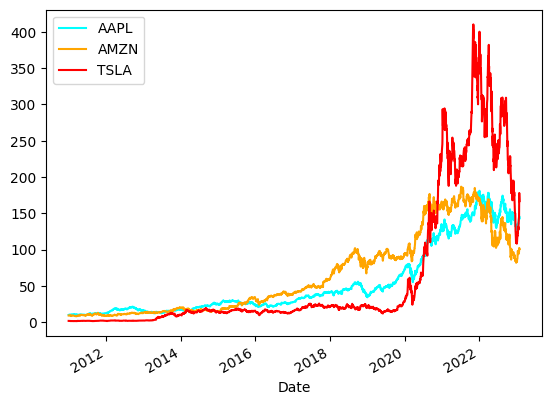

In [1]:
import yfinance as yf  
import matplotlib.pyplot as plt
from datetime import datetime

# Get the stock data specifying the stock ticker, start date, and end date
startDate = '2011-01-01'
endDate = datetime.today().strftime('%Y-%m-%d')
data = yf.download(['TSLA', 'AMZN', 'AAPL'], startDate, endDate)

# Plot the current close prices
prices = data["Adj Close"]
ax = prices.plot.line(color={'AAPL': 'cyan', 'AMZN': 'orange', 'TSLA': 'red'})

In [2]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Seperate stock data
amazon = prices["AMZN"]
apple = prices["AAPL"]
tesla = prices["TSLA"]
tesla.name = "TSLA, current value"

# Amazon: Offset back in X years
offsetByYears = 5
magnifyBy = 3.33
amazonModName = "AMZN, magnified " + str(magnifyBy) + " times and shifted " + str(offsetByYears) + "years"
amazonMod = pd.Series(data = amazon.values * magnifyBy, index = amazon.index + DateOffset(years=offsetByYears), name = amazonModName)

# Apple: Offset back in X years
offsetByYears = 5
magnifyBy = 8.33
appleModName = "AAPL, magnified " + str(magnifyBy) + " times and shifted " + str(offsetByYears) + "years"
appleMod = pd.Series(data = apple.values * magnifyBy, index = apple.index + DateOffset(years=offsetByYears), name = appleModName)

_CudaDeviceProperties(name='Quadro RTX 3000', major=7, minor=5, total_memory=6143MB, multi_processor_count=30)


C:\Users\bora.okumusoglu\AppData\Local\Temp\ipykernel_24384\3989127040.py:30: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  Ydata = tesla.index.astype(int).astype(float).tolist()
C:\Users\bora.okumusoglu\AppData\Local\Temp\ipykernel_24384\3989127040.py:31: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion overflows.
  Ydata += amazonMod.index.astype(int).astype(float).tolist()
C:\Users\bora.okumusoglu\AppData\Local\Temp\ipykernel_24384\3989127040.py:32: FutureWarning: The behavior of .astype from datetime64[ns] to int32 is deprecated. In a future version, this astype will return exactly the specified dtype instead of int64, and will raise if that conversion o

Epoch 500/50000, Loss = 0.3764
Epoch 1000/50000, Loss = 0.2558
Epoch 1500/50000, Loss = 0.1554
Epoch 2000/50000, Loss = 0.1344
Epoch 2500/50000, Loss = 0.1299
Epoch 3000/50000, Loss = 0.1271
Epoch 3500/50000, Loss = 0.1250
Epoch 4000/50000, Loss = 0.1233
Epoch 4500/50000, Loss = 0.1219
Epoch 5000/50000, Loss = 0.1207
Epoch 5500/50000, Loss = 0.1196
Epoch 6000/50000, Loss = 0.1186
Epoch 6500/50000, Loss = 0.1178
Epoch 7000/50000, Loss = 0.1171
Epoch 7500/50000, Loss = 0.1164
Epoch 8000/50000, Loss = 0.1158
Epoch 8500/50000, Loss = 0.1152
Epoch 9000/50000, Loss = 0.1146
Epoch 9500/50000, Loss = 0.1141
Epoch 10000/50000, Loss = 0.1137
Epoch 10500/50000, Loss = 0.1133
Epoch 11000/50000, Loss = 0.1129
Epoch 11500/50000, Loss = 0.1125
Epoch 12000/50000, Loss = 0.1122
Epoch 12500/50000, Loss = 0.1119
Epoch 13000/50000, Loss = 0.1116
Epoch 13500/50000, Loss = 0.1114
Epoch 14000/50000, Loss = 0.1111
Epoch 14500/50000, Loss = 0.1109
Epoch 15000/50000, Loss = 0.1107
Epoch 15500/50000, Loss = 0.11

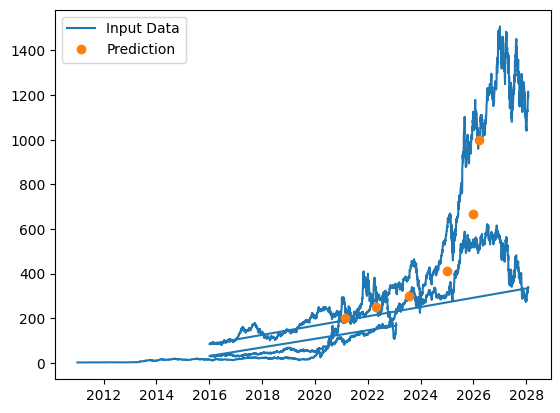

In [3]:
# train NN with all this data, and predict dates for a set of price targets (Xtargets below)

# import necessary libraries
import torch
import numpy as np

# Set device for GPU acceleration if available
# cuda (pc-gpu) or mps (apple-silicon)
import platform
sys = platform.system()
if sys == 'Windows' or sys == 'Linux':
    if torch.cuda.is_available(): 
        device = 'cuda' 
        print(torch.cuda.get_device_properties(0)) 
elif sys == 'Darwin':
    if torch.backends.mps.is_available(): 
        device = 'mps' 
        print("Mac Silicon GPU") 
else:
    device = 'cpu'

# set random seed for reproducibility
torch.manual_seed(0)

# prepare the data
Xdata = tesla.values.astype(float).tolist()
Xmax = max(Xdata)
Xdata += amazonMod.values.astype(float).tolist()
Xdata += appleMod.values.astype(float).tolist()
Ydata = tesla.index.astype(int).astype(float).tolist()
Ydata += amazonMod.index.astype(int).astype(float).tolist()
Ydata += appleMod.index.astype(int).astype(float).tolist()
Xtargets = [200.0, 250.0, 300.0, Xmax, 666.0, 999.0]

X = torch.tensor(Xdata).to(device).unsqueeze(-1)
Y = torch.tensor(Ydata).to(device).unsqueeze(-1)
X_t = np.array(Xtargets)

# normalize the data
X_mean, X_std = X.mean(), X.std()
Y_mean, Y_std = Y.mean(), Y.std()
X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

# define the model
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size).to(device)
        self.fc2 = torch.nn.Linear(hidden_size, output_size).to(device)
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.functional.relu(x).to(device)
        x = self.fc2(x)
        return x

model = MLP(1, 1000, 1).to(device)

# define the loss function and the optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) #normalization allows use of standard lr for all data ranges

# Set the number of epochs
num_epochs = 50000

for epoch in range(num_epochs):
    # forward pass
    Y_pred = model(X_norm)# calculate the loss
    loss = loss_fn(Y_pred, Y_norm)

    # zero the gradients
    optimizer.zero_grad()

    # backpropagate the loss
    loss.backward()

    # update the weights and biases
    optimizer.step()
    
    # Print progress
    if (epoch + 1) % 500 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss = {loss.item():.4f}')

# Test the model
X_test = torch.tensor(X_t, dtype=torch.float).to(device).view(-1, 1)
X_test_norm = (X_test - X_mean) / X_std
y_pred = model(X_test_norm) * Y_std + Y_mean
print(y_pred)

# Graphing of results
import matplotlib.pyplot as plt

# Normal graphing for world population data
#plt.plot(X.numpy(), Y.numpy(), label='Input Data')
#plt.plot(X_test.numpy(), y_pred.detach().numpy(), 'o', label='Prediction')

# Format dates
Ynp = Y.cpu().numpy().astype(float)
Yflt = np.ndarray.flatten(Ynp).tolist()
Ydata_plot = pd.to_datetime(Yflt)

Yp_np = y_pred.cpu().detach().numpy().astype(float)
Yp_flt = np.ndarray.flatten(Yp_np).tolist()
Yp_data_plot = pd.to_datetime(Yp_flt)

# Invert graphing
plt.plot(Ydata_plot, X.cpu().numpy(), label='Input Data')
plt.plot(Yp_data_plot, X_test.cpu().numpy(), 'o', label='Prediction')

plt.legend()
plt.show()

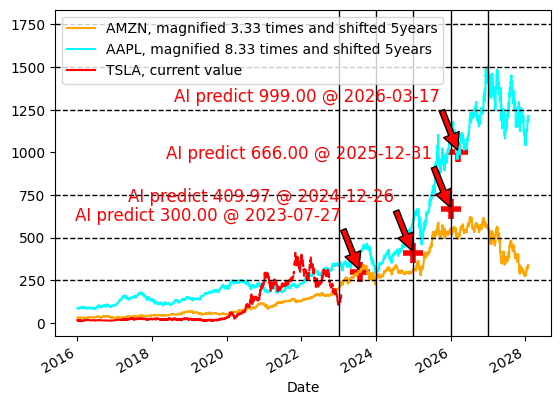

In [5]:
# Better graphical output

# Combine all back
a = pd.DataFrame(amazonMod)
b = a.join(appleMod)
compare = b.join(tesla)
ax = compare.plot.line(color={appleModName: "cyan", amazonModName: "orange", tesla.name: "red"})

# Draw lines for intermediate price points
plt.axhline(250, color='black', linestyle='--', lw=1)
plt.axhline(500, color='black', linestyle='--', lw=1)
plt.axhline(750, color='black', linestyle='--', lw=1)
plt.axhline(1250, color='black', linestyle='--', lw=1)
plt.axhline(1500, color='black', linestyle='--', lw=1)
plt.axhline(1750, color='black', linestyle='--', lw=1)

# Draw line for years
plt.axvline('2023-01-01', color='black', lw=1)
plt.axvline('2024-01-01', color='black', lw=1)
plt.axvline('2025-01-01', color='black', lw=1)
plt.axvline('2026-01-01', color='black', lw=1)
plt.axvline('2027-01-01', color='black', lw=1)

# Add points for AI guesses for price targets 
counter = 0
for target in Xtargets:
    
    time = Yp_data_plot[counter]
    
    #only print if prediction is at future time
    if time > pd.Timestamp.now():
            
        label = "AI predict {:.2f}".format(target) + " @ " + time.strftime('%Y-%m-%d')
        
        #label positions for plot
        timeLabel = time.floor('us') - pd.DateOffset(months=6) #offset for text label, flooring to remove convertion warning
        targetLabel = target + 300
        
        plt.scatter(time, target, marker='+', color='red', s=200, linewidths=4)
        
        plt.annotate(label, xy=(time, target), xytext=(timeLabel, targetLabel)
                 ,arrowprops=dict(facecolor='red', shrink=0.05)
                 ,color='red',fontsize=12,horizontalalignment='right')
    counter += 1
    
# Plot and print to pdf and jpg
plt.savefig('TSLAonAMZNAPPL+AI_in' + str(offsetByYears) + 'years@' + endDate + '.pdf', dpi=300, bbox_inches='tight')
plt.savefig('TSLAonAMZNAPPL+AI_in' + str(offsetByYears) + 'years@' + endDate + '.png')